# Set up packages and server

In [1]:
# specify the GPU
import os
os.environ['TORCH_HOME'] = 'your/own/cache/directory'
os.environ['CUDA_VISIBLE_DEVICES'] = '2'

In [2]:
# Data visualization
import plotly.express as px
from ipywidgets import interact

# Data processing
import pandas as pd
import numpy as np
import geopandas as gpd

# Model training
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import copy
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau

import timm
from sklearn.model_selection import train_test_split
# import lightning as L
# from lightning import Trainer
# from lightning.pytorch.callbacks import EarlyStopping, ModelCheckpoint

# Others
import os
import sys
import gc
from pathlib import Path
import os.path


from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image

# project lib
PROJECT_SRC_PATH = os.path.join( '/workspace/workspace/ufo-prediction', 'src-RCA-UFO')
sys.path.append(PROJECT_SRC_PATH)
import dataset

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-7o5jh52f because the default path (/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [3]:
torch.cuda.empty_cache()

In [4]:
# Check is GPU is enabled
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device: {}".format(device))

# Get specific GPU model
if str(device) == "cuda:0":
  print("GPU: {}".format(torch.cuda.get_device_name(0)))

Device: cuda:0
GPU: NVIDIA A100-PCIE-40GB


# 2. Load and preprocess the training and validation data

In [6]:
directories = [
    Path('/workspace/workspace/ufo-prediction/image_data_NLD'),
    Path('/workspace/workspace/ufo-prediction/image_data_ESP'),  # Add your second directory path here
    Path('/workspace/workspace/ufo-prediction/image_data_FRA'),
    Path('/workspace/workspace/ufo-prediction/image_data_NLD_adv'),
    Path('/workspace/workspace/ufo-prediction/image_data_ESP_adv'),  # Add your second directory path here
    Path('/workspace/workspace/ufo-prediction/image_data_FRA_adv'),
   # Add your third directory path here
]

filepaths = pd.Series(
    [item for directory in directories for item in directory.glob('**/*.jpg')],
    name='Filepath'
).astype(str)

def get_age_bracket(age):
    if 1900 <= age <= 1924:
        return '1900-1924'
    elif 1925 <= age <= 1945:
        return '1925-1945'
    elif 1946 <= age <= 1959:
        return '1946-1959'
    elif 1960 <= age <= 1969:
        return '1960-1969'
    elif 1970 <= age <= 1984:
        return '1970-1984'
    elif 1985 <= age <= 1999:
        return '1985-1999'
    elif 2000 <= age <= 2050:
        return '2000-2050'
    else:
        return 'Unknown'  # For ages outside the specified brackets or if age couldn't be determined


def extract_age_and_name(filepath):
    filename = os.path.basename(filepath)  # Get the filename from the filepath
    age_and_name = filename.split('.')[0]  # Split by dot and take the first part
    age = ''.join(filter(str.isdigit, age_and_name))[:4]  # Extract first 4 digits for age
    if age:  # Ensure age string is not empty
        age = int(age)
        age_bracket = get_age_bracket(age)  # Get the age bracket
    else:  # Default age if no digits found
        age_bracket = 'Unknown'
    return age_bracket

age_bracket_to_int = {
    '1900-1924': 0,
    '1925-1945': 1,
    '1946-1959': 2,
    '1960-1969': 3,
    '1970-1984': 4,
    '1985-1999': 5,
    '2000-2050': 6
}

age_brackets = pd.Series(filepaths.apply(lambda x: extract_age_and_name(x)), name='Age Brackets')
filtered_age_brackets = age_brackets[age_brackets != 'Unknown']
filtered_filepaths = filepaths[age_brackets != 'Unknown']
trainval_df = pd.concat([filtered_filepaths, filtered_age_brackets], axis=1).sample(frac=1.0, random_state=1).reset_index(drop=True)
trainval_df['Target'] = trainval_df['Age Brackets'].map(age_bracket_to_int)

In [7]:
train_df, valtest_df = train_test_split(trainval_df, train_size=0.6, shuffle=True, random_state=1)
val_df, test_df = train_test_split(valtest_df, train_size=0.7, shuffle=True, random_state=1)

In [8]:
class AgeBracketDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx, 0]
        image = Image.open(img_path).convert("RGB")
        label = int(self.dataframe.iloc[idx, 2])  # Assuming the label/target is in the third column

        if self.transform:
            image = self.transform(image)

        return image, label


In [9]:
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),  # ResNet-18 expects 224x224 inputs
    transforms.RandomHorizontalFlip(),  # A common form of augmentation
    #transforms.RandomRotation(15),  # Rotates the image by up to 15 degrees
    #transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),  # Randomly jitters color
    #transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalization
])

val_test_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_dataset = AgeBracketDataset(train_df, transform=train_transforms)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

val_dataset = AgeBracketDataset(val_df, transform=val_test_transforms)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)

test_dataset = AgeBracketDataset(val_df, transform=val_test_transforms)
test_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)

# 3. Train model

In [10]:
def train_and_evaluate_val_loss(model, train_loader, val_loader, optimizer, criterion, scheduler, num_epochs=50, patience=7):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    best_val_loss = float('inf')  # Initialize the best validation loss as infinity
    best_model_wts = copy.deepcopy(model.state_dict())
    epochs_no_improve = 0
    early_stop = False

    for epoch in range(num_epochs):
        model.train()  # Set model to training mode
        running_loss = 0.0

        # Training phase
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        # Validation phase
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

        avg_val_loss = val_loss / len(val_loader)

        print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {running_loss / len(train_loader):.4f}, Validation Loss: {avg_val_loss:.4f}')
        
        scheduler.step(avg_val_loss)  # Learning rate scheduler step based on validation loss

        # Check for improvement based on validation loss
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        # Early stopping check
        if epochs_no_improve >= patience:
            print(f'Early stopping triggered after {epoch + 1} epochs.')
            early_stop = True
            break
    
    if not early_stop:
        print('Reached maximum epoch limit.')

    # Load best model weights based on lowest validation loss
    model.load_state_dict(best_model_wts)
    return best_val_loss  # Return the best validation loss achieved


In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Best Parameters
batch_size = 32
learning_rate = 0.0005
unfreeze_option = 'last_plus_one'

# Initialize the model
model = models.resnet18(pretrained=True)

# Freeze all layers first
for param in model.parameters():
    param.requires_grad = False

# Unfreeze the selected layers
if unfreeze_option == 'last':
    for param in model.fc.parameters():
        param.requires_grad = True
elif unfreeze_option == 'last_plus_one':
    for param in model.layer4.parameters():
        param.requires_grad = True
    for param in model.fc.parameters():
        param.requires_grad = True

model.to(device)

# Setup DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Setup optimizer, criterion, and scheduler
optimizer = Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=learning_rate)
criterion = nn.CrossEntropyLoss()
scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.1, patience=5, verbose=True)

# Train the model
train_and_evaluate_val_loss(model, train_loader, val_loader, optimizer, criterion, scheduler, num_epochs=50, patience=7)

/.local/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch 1/50, Training Loss: 2.0553, Validation Loss: 1.8293
Epoch 2/50, Training Loss: 1.8041, Validation Loss: 1.7430
Epoch 3/50, Training Loss: 1.7343, Validation Loss: 1.7166
Epoch 4/50, Training Loss: 1.6755, Validation Loss: 1.6456
Epoch 5/50, Training Loss: 1.6213, Validation Loss: 1.6217
Epoch 6/50, Training Loss: 1.5628, Validation Loss: 1.5709
Epoch 7/50, Training Loss: 1.5095, Validation Loss: 1.5623
Epoch 8/50, Training Loss: 1.4623, Validation Loss: 1.5072
Epoch 9/50, Training Loss: 1.4094, Validation Loss: 1.4809
Epoch 10/50, Training Loss: 1.3610, Validation Loss: 1.5158
Epoch 11/50, Training Loss: 1.3111, Validation Loss: 1.5086
Epoch 12/50, Training Loss: 1.2577, Validation Loss: 1.4883
Epoch 13/50, Training Loss: 1.2166, Validation Loss: 1.4797
Epoch 14/50, Training Loss: 1.1950, Validation Loss: 1.4275
Epoch 15/50, Training Loss: 1.1417, Validation Loss: 1.4551
Epoch 16/50, Training Loss: 1.0994, Validation Loss: 1.4688
Epoch 17/50, Training Loss: 1.0749, Validation Lo

1.3996848606048746

## 4. Prepare the Test DataLoader

Test Accuracy: 0.55621
Test Precision: 0.56261
Test Recall: 0.55621
Test F1-Score: 0.55540


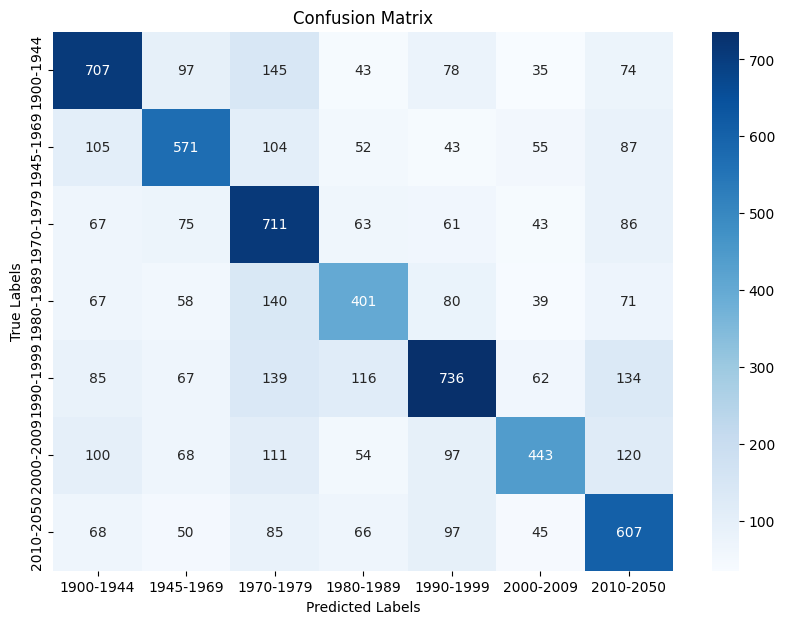

In [13]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import matplotlib.pyplot as plt

# Evaluate the model
model.eval()
true_classes = []
predicted_classes = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        true_classes.extend(labels.cpu().numpy())
        predicted_classes.extend(predicted.cpu().numpy())

# Convert lists to numpy arrays for evaluation
true_classes = np.array(true_classes)
predicted_classes = np.array(predicted_classes)

# Compute metrics
accuracy = accuracy_score(true_classes, predicted_classes)
precision, recall, f1, _ = precision_recall_fscore_support(true_classes, predicted_classes, average='weighted')

print(f"Test Accuracy: {accuracy:.5f}")
print(f"Test Precision: {precision:.5f}")
print(f"Test Recall: {recall:.5f}")
print(f"Test F1-Score: {f1:.5f}")

# Plot confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['1900-1944', '1945-1969', '1970-1979','1980-1989', '1990-1999', '2000-2009', '2010-2050'], yticklabels=['1900-1944', '1945-1969', '1970-1979','1980-1989', '1990-1999', '2000-2009', '2010-2050'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [14]:
class CustomDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx, 0]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, img_path

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Assuming test_df is your DataFrame
test_dataset = CustomDataset(dataframe=test_df, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


# 5. Infer age brackets

In [15]:
model.eval()  # Set model to evaluation mode
predictions = []
file_paths = []

with torch.no_grad():
    for inputs, paths in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        predictions.extend(predicted.cpu().numpy())
        file_paths.extend(paths)


# 6. Concatenate Building ID and use to merge to rca-ufo dataset

In [16]:
def extract_building_id(filepath):
    """
    Extracts the building ID from the given filepath string.
    Knowing that the building ID always contains an underscore and considering the filename
    format '[age_right]_[building_id]_[subscript].jpg', this function returns the 'building_id'.
    """
    # Isolate the filename from the filepath
    filename = filepath.split('/')[-1]
    # Split the filename at underscores
    parts = filename.split('_')
    # Considering the first part is age_right and the last part is the subscript with .jpg,
    # the building ID is everything in between.
    # Rejoin the middle parts to account for underscores within the building ID itself.
    building_id = '_'.join(parts[1:-1])
    return building_id

# Use the updated function to extract building IDs from file paths
building_ids = [extract_building_id(path) for path in file_paths]

# Prepare the predictions DataFrame with the correct building IDs
predictions_df = pd.DataFrame({
    'id': building_ids,
    'CNN_age_bracket': predictions  # Or map to your age bracket strings if needed
})

In [21]:
unique_ids = predictions_df['id'].unique()
print(len(unique_ids))
print(len(predictions_df))


2113
3218


In [22]:
import numpy as np

# Assuming predictions_df is already defined and has 'id' and 'CNN_age_bracket' columns

# Step 1 & 2: Group by 'id' and 'CNN_age_bracket' and count occurrences
age_bracket_counts = predictions_df.groupby(['id', 'CNN_age_bracket']).size().reset_index(name='counts')

# Determine the most frequent age bracket for each 'id'
def most_frequent_age_bracket(sub_df):
    max_count = sub_df['counts'].max()
    most_frequent = sub_df[sub_df['counts'] == max_count]
    if len(most_frequent) == 1:
        # If there's a single most frequent value, return it
        return most_frequent['CNN_age_bracket'].values[0]
    else:
        # If there's a tie, calculate the average and round to the nearest whole number
        avg = most_frequent['CNN_age_bracket'].astype(float).mean()
        return round(avg)

# Apply the function to each 'id' group
unique_predictions = age_bracket_counts.groupby('id').apply(most_frequent_age_bracket).reset_index()
unique_predictions.columns = ['id', 'CNN_age_bracket']

# Now, unique_predictions contains unique ids with the selected CNN_age_bracket
print(len(unique_predictions['id'].unique()), len(unique_predictions))


2113 2113


In [23]:
# List of countries to loop through
countries = ['NLD', 'ESP', 'FRA']
base_path = '/workspace/workspace/ufo-prediction/demo'
all_data = []  # To store data from all countries

for country in countries:
    # Construct the path to the pickle file
    path_data = os.path.join(base_path, f'df-{country}.pkl')
    # Read the country-specific DataFrame
    df_country = pd.read_pickle(path_data)
    print(f' Read data for {country}')
    # Merge with predictions DataFrame
    merged_df = pd.merge(unique_predictions, df_country, on='id', how='left')
    print(f' Merged data for {country}')
    # Append to the list for concatenation later
    all_data.append(merged_df)

# Concatenate all merged DataFrames
all_df = pd.concat(all_data, ignore_index=True)

 Read data for NLD
 Merged data for NLD
 Read data for ESP
 Merged data for ESP
 Read data for FRA
 Merged data for FRA


In [25]:
all_df

,id,CNN_age_bracket,source_file,dist_to_closest_int,av_footprint_area_within_buffer_100,street_betweeness_global_max_within_buffer_500,av_elongation_within_buffer_500,geometry,std_building_footprint_city,block,...,buildings_within_buffer_100,street_betweeness_global_max_within_buffer_100,TouchesIndexes,street_based_block_av_phi_inter_buffer_500,total_length_street_city,total_buildings_footprint_city,Phi,street_based_block_std_area_inter_buffer_100,type,neighborhood
0,v0.1-ESP.1.1.6.4_1-20861,6,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,v0.1-ESP.1.1.6.8_1-11839,3,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,v0.1-ESP.1.1.6.8_1-12762,6,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,v0.1-ESP.1.1.6.8_1-12773,0,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,v0.1-ESP.1.1.6.8_1-7831,2,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6334,v0.1-NLD.9.9_1-21525,4,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6335,v0.1-NLD.9.9_1-37,6,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6336,v0.1-NLD.9.9_1-8258,4,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6337,v0.1-NLD.9.9_1-9419,2,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [26]:

# Select columns to consider for NA (all but 'CNN_age_bracket')
cols_to_check = all_df.columns.difference(['CNN_age_bracket', 'id'])

# Drop rows where all the selected columns are NA
cleaned_df = all_df.dropna(subset=cols_to_check, how='all')

# Now, cleaned_df should have rows dropped where every column except 'CNN_age_bracket' was NA
print(len(cleaned_df))


2113


In [27]:
cleaned_df

,id,CNN_age_bracket,source_file,dist_to_closest_int,av_footprint_area_within_buffer_100,street_betweeness_global_max_within_buffer_500,av_elongation_within_buffer_500,geometry,std_building_footprint_city,block,...,buildings_within_buffer_100,street_betweeness_global_max_within_buffer_100,TouchesIndexes,street_based_block_av_phi_inter_buffer_500,total_length_street_city,total_buildings_footprint_city,Phi,street_based_block_std_area_inter_buffer_100,type,neighborhood
765,v0.1-NLD.1.10_1-22487,0,NL_lod12_2d_pand_2,80.417349,312.445480,0.135796,0.655093,POINT (4082503.037 3342366.916),343.163256,b6ee09d8,...,40.0,0.017439,[22487],0.429858,942530.341312,2.917612e+06,0.579591,2.249724e+06,NaN,53d62edb
766,v0.1-NLD.1.10_1-2274,2,NL_lod12_2d_pand_2,34.591707,232.236078,0.307461,0.674780,POINT (4084008.848 3334528.979),343.163256,8ae7baf0,...,53.0,0.087692,"[2274, 20436, 9479, 2923]",0.432832,942530.341312,2.917612e+06,0.303103,2.066548e+06,NaN,f73dc321
767,v0.1-NLD.1.11_1-12774,0,NL_lod12_2d_pand_2,19.308712,109.864304,0.056066,0.703447,POINT (4089711.386 3337663.673),424.396815,1c7710d4,...,27.0,0.051693,[12774],0.329155,888712.235310,2.887787e+06,0.429084,5.559368e+05,NaN,bde9e9aa
768,v0.1-NLD.1.11_1-18467,3,NL_lod12_2d_pand_2,11.666631,106.177111,0.157550,0.644019,POINT (4099114.983 3336947.589),424.396815,3537afeb,...,111.0,0.093344,"[5031, 18467]",0.411736,888712.235310,2.887787e+06,0.558643,1.617388e+06,NaN,d2b16a1a
769,v0.1-NLD.1.11_1-4079,6,NL_lod12_2d_pand_2,29.881210,126.434745,0.110367,0.654707,POINT (4099251.581 3337197.490),424.396815,1b072026,...,52.0,0.103494,[4079],0.436095,888712.235310,2.887787e+06,0.622589,2.046391e+06,NaN,d2b16a1a
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4986,v0.1-FRA.9.3.2.14_1-2431,6,BATIMENT-normandie,17.130284,85.060422,0.118125,0.632948,POINT (3488299.449 3002949.819),240.029254,3d2cb82a,...,8.0,0.099810,[2431],0.225418,608321.057638,1.671174e+06,0.581062,3.541002e+06,residential,479dc141
4987,v0.1-FRA.9.3.4.2_1-5657,3,BATIMENT-normandie,125.131950,63.898899,0.071257,0.603756,POINT (3507369.064 2972866.218),463.258047,2dcbbf61,...,29.0,0.025715,"[5656, 5657]",0.436597,559702.734166,1.836864e+06,0.344796,4.669612e+05,residential,4297c65c
4988,v0.1-FRA.9.3.4.5_1-3976,4,BATIMENT-normandie,146.401342,131.322217,0.101619,0.608976,POINT (3519874.747 2950097.520),223.777076,765a5927,...,25.0,0.072957,[3976],0.394060,647603.388207,1.297290e+06,0.572295,8.878829e+05,residential,08453a55
4989,v0.1-FRA.9.4.2.3_1-2458,3,BATIMENT-normandie,9.294193,82.455834,0.153913,0.644721,POINT (3586273.827 2898541.293),574.200790,6242ac7d,...,87.0,0.071388,"[2458, 6623]",0.351135,209509.759359,1.108007e+06,0.550500,1.189182e+06,residential,03d890dc


In [28]:
# Save the concatenated DataFrame to CSV
output_path = os.path.join('/workspace/workspace/ufo-prediction/demo/ufo-CNN_ALL.csv')
cleaned_df.to_csv(output_path, index=False)

In [29]:
gc.collect()

0